# **Product Recognition of Books**

## Image Processing and Computer Vision - Assignment Module \#1

Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in library or bookstore settings to build a system that identifies books on shelves.

Such a system could assist in:

- Helping visually impaired users locate books by title/author;
- Automating inventory management (e.g., detecting misplaced or out-of-stock books);
- Enabling faster book retrieval by recognizing spine text or cover designs.


## Task

Develop a computer vision system that, given a reference image for each book, is able to identify such book from one picture of a shelf.

<figure>
<a href="https://ibb.co/pvLVjbM5"><img src="https://i.ibb.co/svVx9bNz/example.png" alt="example" border="0"></a>
</figure>

For each type of product displayed on the shelf, the system should compute a bounding box aligned with the book spine or cover and report:

1. Number of instances;
1. Dimension of each instance (area in pixel of the bounding box that encloses each one of them);
1. Position in the image reference system of each instance (four corners of the bounding box that enclose them);
1. Overlay of the bounding boxes on the scene images.

<font color="red"><b>Each step of this assignment must be solved using traditional computer vision techniques.</b></font>

#### Example of expected output

```
Book 0 - 2 instance(s) found:
  Instance 1 {top_left: (100,200), top_right: (110, 220), bottom_left: (10, 202), bottom_right: (10, 208), area: 230px}
  Instance 2 {top_left: (90,310), top_right: (95, 340), bottom_left: (24, 205), bottom_right: (23, 234), area: 205px}
Book 1 – 1 instance(s) found:
.
.
.
```


## Data

Two folders of images are provided:

- **Models**: contains one reference image for each product that the system should be able to identify;
- **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

# Set latex font for plots cmu
plt.rcParams["font.family"] = "cmr10"
plt.rcParams["font.size"] = 16

In [2]:
MODELS_FOLDER = "./dataset/models"
SCENES_FOLDER = "./dataset/scenes"

# read all the images inside all models and scene
models_images = []
scenes_images = []

for folder, image_list, image_name, image_ext in [
    (MODELS_FOLDER, models_images, "model", "png"),
    (SCENES_FOLDER, scenes_images, "scene", "jpg"),
]:
    num_images = len(
        [name for name in os.listdir(folder) if name.startswith(image_name)]
    )
    for i in range(num_images):
        image_list.append(
            cv2.imread(os.path.join(folder, f"{image_name}_{i}.{image_ext}"))
        )

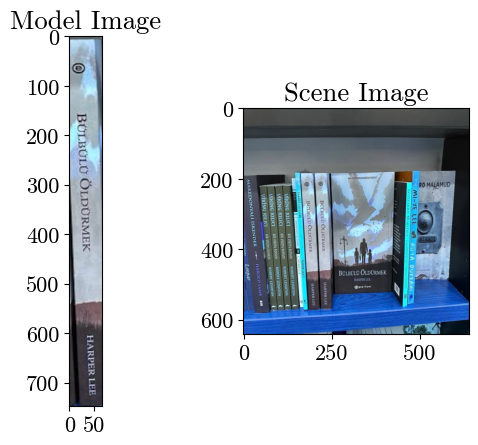

In [3]:
plt.subplot(1, 2, 1)
plt.imshow(models_images[0])
plt.title("Model Image")

plt.subplot(1, 2, 2)
plt.imshow(scenes_images[26])
plt.title("Scene Image")

plt.show()

In [4]:
img_model = models_images[0]  # Use the first model image
img_scene = scenes_images[26]  # Use the first scene image
model_gray = cv2.cvtColor(img_model, cv2.COLOR_BGR2GRAY)
scene_gray = cv2.cvtColor(img_scene, cv2.COLOR_BGR2GRAY)

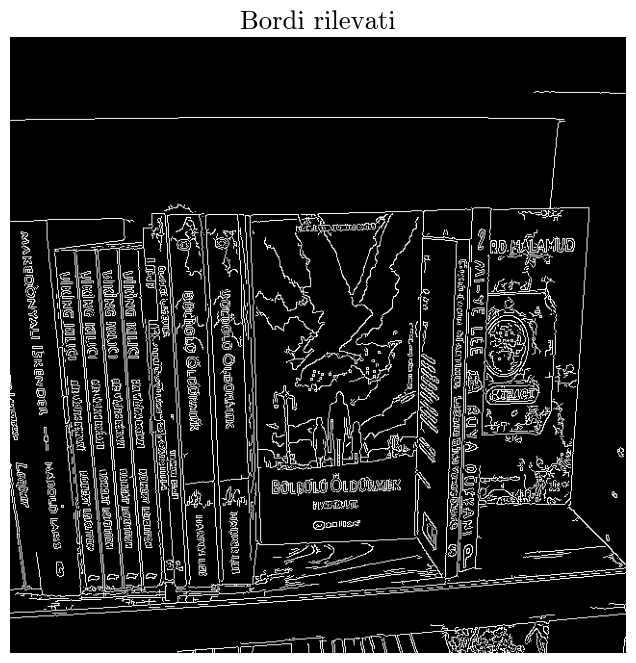

In [5]:
import cv2
import numpy as np

# Rileva i bordi con Canny
edges = cv2.Canny(scene_gray, 50, 150)

plt.figure(figsize=(10, 8))
plt.imshow(edges, cmap="gray")  # cmap='gray' per immagini in scala di grigi
plt.title("Bordi rilevati")
plt.axis("off")
plt.show()

Found 23 horizontal and 60 vertical lines
Can form 447810 rectangles
Found 51788 intersections


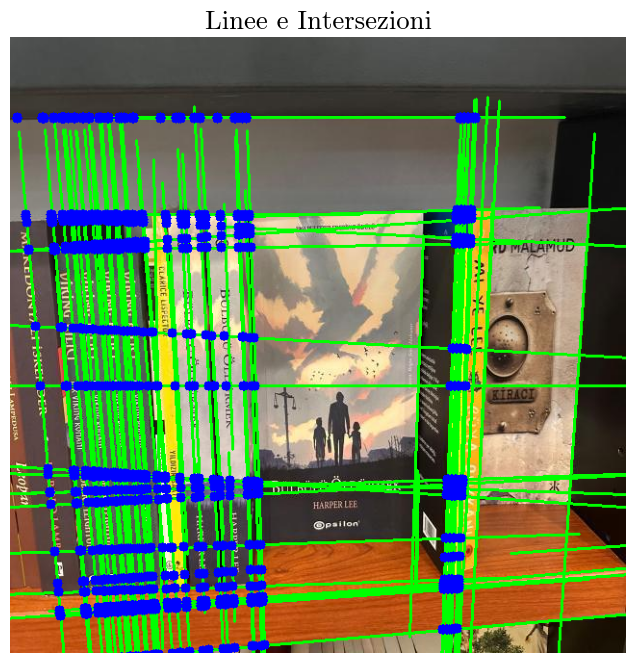

In [6]:
lines = cv2.HoughLinesP(
    edges, 1, np.pi / 180, threshold=100, minLineLength=30, maxLineGap=50
)

# Separate horizontal and vertical lines
horizontal = []
vertical = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    # Extend the lines a bit
    m = (y2 - y1) / (x2 - x1 + 1e-6)  # slope
    length = abs(x2 - x1) // 4
    if x1 < x2:
        x1 -= length
        y1 -= int(m * length)
        x2 += length
        y2 += int(m * length)
    if x2 < x1:
        x1 += length
        y1 += int(m * length)
        x2 -= length
        y2 -= int(m * length)
    if abs(m) < 0.1:  # horizontal
        horizontal.append((x1, y1, x2, y2))
    elif abs(m) > 10:  # vertical
        vertical.append((x1, y1, x2, y2))
    # if abs(y2 - y1) < 25:  # horizontal
    #     horizontal.append((x1,y1,x2,y2))
    # elif abs(x2 - x1) < 25:  # vertical
    #     vertical.append((x1,y1,x2,y2))

print(f"Found {len(horizontal)} horizontal and {len(vertical)} vertical lines")
h = len(horizontal)
v = len(vertical)


def find_intersections():
    intersections = []
    num_rectangles = (h * (h - 1) // 2) * (v * (v - 1) // 2)
    print(f"Can form {num_rectangles} rectangles")
    for i1, h1 in enumerate(horizontal):
        for i2, h2 in enumerate(horizontal):
            if i2 < i1:
                continue
            m1 = (h1[3] - h1[1]) / (h1[2] - h1[0] + 1e-6)
            m2 = (h2[3] - h2[1]) / (h2[2] - h2[0] + 1e-6)
            q1 = h1[1] - m1 * h1[0]
            q2 = h2[1] - m2 * h2[0]

            if abs(q1 - q2) > 750 or abs(q1 - q2) < 200:
                continue

            for j1, v1 in enumerate(vertical):
                for j2, v2 in enumerate(vertical):
                    if j2 < j1:
                        continue

                    m3 = (v1[3] - v1[1]) / (v1[2] - v1[0] + 1e-6)
                    m4 = (v2[3] - v2[1]) / (v2[2] - v2[0] + 1e-6)
                    q3 = v1[1] - m3 * v1[0]
                    q4 = v2[1] - m4 * v2[0]

                    if abs(q3 - q4) > 400 or abs(q3 - q4) < 200:
                        continue

                    # print(f"Rectangle formed by lines {i1}, {i2} and {j1}, {j2}")
                    # Find intersection points
                    # Intersection of h1 and v1
                    x_h1_v1 = (q3 - q1) / (m1 - m3 + 1e-6)
                    y_h1_v1 = m1 * x_h1_v1 + q1
                    intersections.append((int(x_h1_v1), int(y_h1_v1)))

                    # Intersection of h1 and v2
                    x_h1_v2 = (q4 - q1) / (m1 - m4 + 1e-6)
                    y_h1_v2 = m1 * x_h1_v2 + q1
                    intersections.append((int(x_h1_v2), int(y_h1_v2)))

                    # Intersection of h2 and v1
                    x_h2_v1 = (q3 - q2) / (m2 - m3 + 1e-6)
                    y_h2_v1 = m2 * x_h2_v1 + q2
                    intersections.append((int(x_h2_v1), int(y_h2_v1)))

                    # Intersection of h2 and v2
                    x_h2_v2 = (q4 - q2) / (m2 - m4 + 1e-6)
                    y_h2_v2 = m2 * x_h2_v2 + q2
                    intersections.append((int(x_h2_v2), int(y_h2_v2)))

                    # return intersections

                # Here we have a rectangle defined by (h1, h2, v1, v2)
                # You can store or process it as needed
    return intersections


intersections = find_intersections()
print(f"Found {len(intersections)} intersections")
# for h in horizontal:
#     for v in vertical:
#         x1_h, y1_h, x2_h, y2_h = h
#         x1_v, y1_v, x2_v, y2_v = v

#         m1, q1 = (y2_h - y1_h) / (x2_h - x1_h + 1e-6), y1_h - (y2_h - y1_h) / (x2_h - x1_h + 1e-6) * x1_h
#         m2, q2 = (y2_v - y1_v) / (x2_v - x1_v + 1e-6), y1_v - (y2_v - y1_v) / (x2_v - x1_v + 1e-6) * x1_v

#         x_inter = (q2 - q1) / (m1 - m2 + 1e-6)
#         y_inter = m1 * x_inter + q1

#         intersections.append((int(x_inter), int(y_inter)))

# Draw lines and intersections
line_image = img_scene.copy()
for x1, y1, x2, y2 in horizontal + vertical:
    cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
for x, y in intersections:
    cv2.circle(line_image, (x, y), 5, (255, 0, 0), -1)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.title("Linee e Intersezioni")
plt.axis("off")
plt.show()

In [ ]:
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Disegna tutti i contorni sull'immagine originale
contours_image = cv2.drawContours(img_scene.copy(), contours, -1, (0, 255, 0), 2)

# print(contours)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(contours_image, cv2.COLOR_BGR2RGB))
plt.title("Tutti i contorni")
plt.axis("off")
plt.show()

In [ ]:
rectangles = []
for contour in contours:
    if len(contour) < 4:
        continue
    if cv2.contourArea(contour) < 1000:
        continue
    # Approximate contour to polygon
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    # plot contour e approx
    print(contour, approx)

    plt.figure(figsize=(10, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(
        cv2.cvtColor(
            cv2.drawContours(img_scene.copy(), [contour], -1, (0, 255, 0), 2),
            cv2.COLOR_BGR2RGB,
        )
    )
    plt.title("Contorno originale")
    # plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(
        cv2.cvtColor(
            cv2.drawContours(img_scene.copy(), [approx], -1, (255, 0, 0), 2),
            cv2.COLOR_BGR2RGB,
        )
    )
    plt.title("Contorno approssimato")
    # plt.axis("off")
    plt.show()

    # Check if it has 4 points and is convex
    if len(approx) == 4 and cv2.isContourConvex(approx):
        rectangles.append(approx)

In [ ]:
rectangles_image = cv2.drawContours(img_scene.copy(), rectangles, -1, (0, 255, 0), 2)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(rectangles_image, cv2.COLOR_BGR2RGB))
plt.title("Rettangoli rilevati")
plt.axis("off")
plt.show()

## Evaluation criteria

1. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

2. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed and justified approach that solves more or all instances.
